In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import zscore
from sklearn.pipeline import Pipeline   
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,    
    mean_absolute_percentage_error,
    r2_score,
)

## Data preprocessing 

### Read data and rename column, fill missing value with Q1 because Defender and Attacker often have weaker stats outside their field.

In [2]:
df = pd.read_csv('players_transformed.csv')
df = df.drop(df.columns[0], axis=1)
# Define a dictionary mapping old column names to new ones
column_renaming = {
    'name': 'Name',
    'age': 'Age',
    'nationality': 'Nationality',
    'club': 'Club',
    'height': 'Height',
    'weight': 'Weight',
    'foot': 'Foot',
    'total_matches': 'Total Matches',
    'total_goals': 'Total Goals',
    'total_assists': 'Total Assists',
    'total_goals_conceded': 'Total Goals Conceded',
    'total_cs': 'Total CS',
    'total_yellow': 'Total Yellow Cards',
    'total_red': 'Total Red Cards',
    'shot_accuracy': 'Shot Accuracy',
    'pass_completion_rate': 'Pass Completion Rate',
    'cross_completion_rate': 'Cross Completion Rate',
    'dribble_success_rate': 'Dribble Success Rate',
    'tackles': 'Tackles',
    'interception': 'Interceptions',
    'market_value': 'Market Value',
    'titles': 'Titles',
    'injuries': 'Injuries',
    'general_position': 'General Position'
}
df.rename(columns=column_renaming, inplace=True)
# Columns to fill missing values
columns_to_fill = ['Total Assists', 'Total CS', 'Total Goals Conceded']

# Function to fill missing values with random values in IQR range
def fill_with_random_iqr(df, columns):
    for col in columns:
        q1 = df[col].quantile(0.25)  # Calculate Q1
        q3 = df[col].quantile(0.75)  # Calculate Q3
        iqr_range = (q1, q3)  # Define IQR range
        # Replace NaN with random values within the IQR range
        df[col] = df[col].apply(
            lambda x: np.random.uniform(q1, q3) if pd.isna(x) else x
        )

# Apply the function to the specified columns
fill_with_random_iqr(df, columns_to_fill)
df.describe()

,Age,Height,Weight,Total Matches,Total Goals,Total Assists,Total Goals Conceded,Total CS,Total Yellow Cards,Total Red Cards,Shot Accuracy,Pass Completion Rate,Cross Completion Rate,Dribble Success Rate,Tackles,Interceptions,Market Value,Titles,Injuries
count,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000
mean,25.970667,182.638933,74.985600,236.573333,28.217600,18.947542,241.030231,72.655412,34.392000,1.611200,44.107040,80.376528,22.399525,39.747936,8.101867,3.982933,13.329107,2.697067,8.576533
std,4.294730,6.298962,6.339161,142.465605,39.836373,18.316197,98.536345,33.734009,28.141441,1.906788,25.395531,10.022922,18.369196,30.446640,7.379612,4.261306,19.138218,4.350072,9.286377
min,16.000000,162.000000,50.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000
25%,23.000000,178.000000,72.000000,129.000000,5.000000,8.000000,173.939556,52.000000,13.000000,0.000000,33.330000,76.470000,15.000000,0.000000,2.000000,1.000000,3.000000,0.000000,1.000000
50%,26.000000,183.000000,75.000000,226.000000,15.000000,15.403989,240.000000,70.141053,28.000000,1.000000,46.000000,81.000000,21.000000,42.000000,6.000000,3.000000,7.000000,1.000000,6.000000
75%,29.000000,187.000000,78.000000,330.000000,36.000000,24.583443,301.304176,88.213138,50.000000,2.000000,50.000000,86.725000,26.670000,55.560000,12.000000,6.000000,15.500000,3.000000,13.000000
max,44.000000,206.000000,98.000000,785.000000,588.000000,239.000000,766.000000,350.000000,173.000000,14.000000,100.000000,100.000000,100.000000,100.000000,39.000000,24.000000,200.000000,35.000000,79.000000


### Preprocessing and other functions

In [3]:
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df

def plot_all_numerical_columns(df, col):
    """
    Plots all numerical columns in the dataframe against a specified column on the y-axis,
    with 3 plots per row.

    Parameters:
    - df (pd.DataFrame): The dataframe containing the data.
    - col (str): The name of the column to be used as the y-axis.
    """
    # Filter numerical columns in the dataframe
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Remove the y-axis column from the numerical columns
    if col in numerical_columns:
        numerical_columns.remove(col)
    
    # Set up the figure size and grid layout (3 plots per row)
    num_plots = len(numerical_columns)
    num_rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)  # Calculate number of rows needed
    plt.figure(figsize=(15, num_rows * 5))
    
    # Loop through each numerical column and create a scatter plot
    for idx, col_x in enumerate(numerical_columns, 1):
        plt.subplot(num_rows, 3, idx)  # Adjust the grid to fit 3 plots per row
        sns.scatterplot(data=df, x=col_x, y=col, alpha=0.7)
        plt.title(f'Relationship between {col_x} and {col}')
        plt.xlabel(col_x)
        plt.ylabel(col)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_relationship(df, col1, col2):
    """
    Plots the relationship between two columns in a dataframe.

    Parameters:
    - df (pd.DataFrame): The dataframe containing the data.
    - col1 (str): The name of the first column (x-axis).
    - col2 (str): The name of the second column (y-axis).
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=col1, y=col2, alpha=0.7, color='blue')
    plt.title(f'Relationship between {col1} and {col2}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def correlation(df, col):
    """
    Calculates the correlation of all columns in the dataframe with a specified target column.

    Parameters:
    - df (pd.DataFrame): The dataframe containing the data.
    - col (str): The name of the column to calculate correlations with.
    
    Returns:
    - pd.Series: Correlations of each column with the target column.
    """
    df_numeric = df.select_dtypes('number')
    # Ensure the column exists in the dataframe
    if col not in df_numeric.columns:
        raise ValueError(f"Column {col} not found in the dataframe.")
    
    # Calculate correlation of all numerical columns with the target column
    correlations = df_numeric.corr()[col].sort_values(ascending=False)
    
    return correlations

def plot_correlation_matrix_all_cols(df):
    # Compute the correlation matrix
    df_numeric = df.select_dtypes('number')
    correlation_matrix = df_numeric.corr()

    # Set up the figure size
    plt.figure(figsize=(12, 8))

    # Create the heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)

    # Adding title and labels
    plt.title('Correlation Matrix')
    plt.tight_layout()
    
    # Show the plot
    plt.show()

### First we view the correlation of matrix to look for columns that are too highly correlated

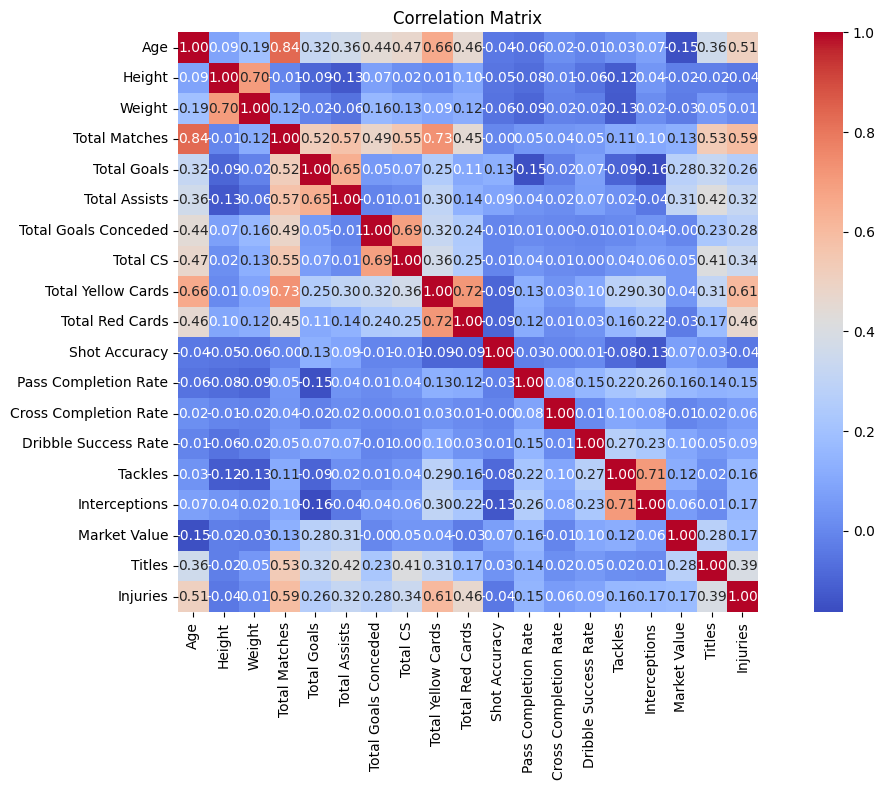

In [4]:
plot_correlation_matrix_all_cols(df)

- Total Matches, Ages are too highly correlated with each other with 0.84. So I will drop total matches.

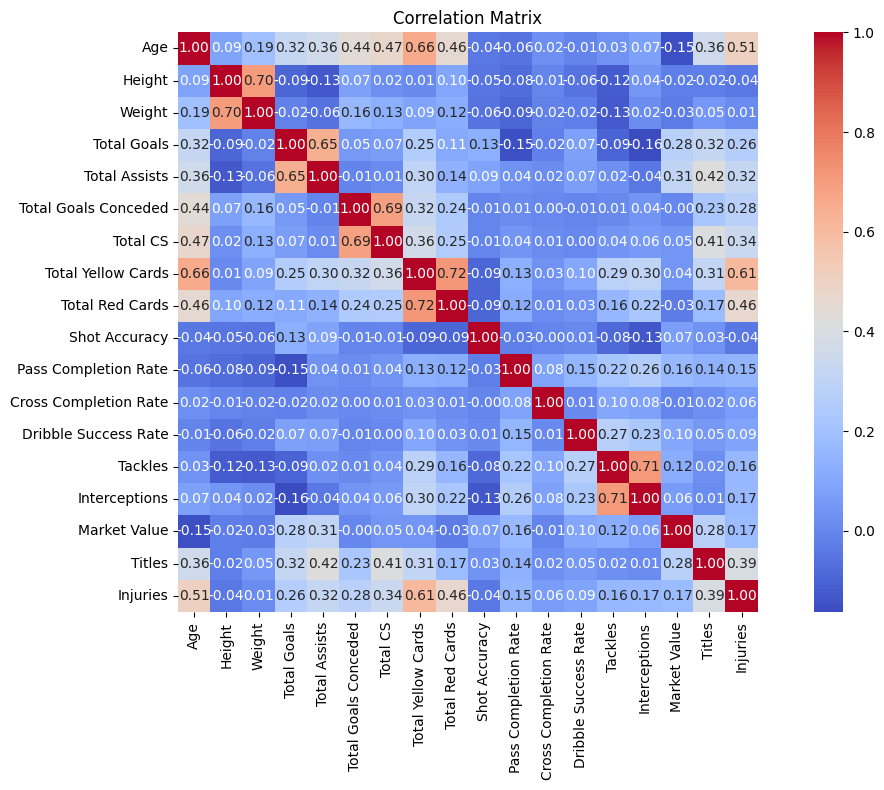

In [5]:
df = df.drop(columns=['Total Matches'])
plot_correlation_matrix_all_cols(df)

### Now we look at our correlation matrix with our target feature: Market Value

In [6]:
correlation_with_target = correlation(df,'Market Value')
print(correlation_with_target)

Market Value             1.000000
Total Assists            0.309622
Titles                   0.277183
Total Goals              0.275098
Injuries                 0.174311
Pass Completion Rate     0.164840
Tackles                  0.121545
Dribble Success Rate     0.098908
Shot Accuracy            0.072832
Interceptions            0.063555
Total CS                 0.045599
Total Yellow Cards       0.043583
Total Goals Conceded    -0.000689
Cross Completion Rate   -0.005260
Height                  -0.021824
Total Red Cards         -0.033657
Weight                  -0.033994
Age                     -0.149697
Name: Market Value, dtype: float64


- We can see that the features don't really correlate with the market value as the highest corr value being total assists: 0.344367

### Preprocess to gain more insights on our data

#### 1. Remove obvious outlier detected using visualization

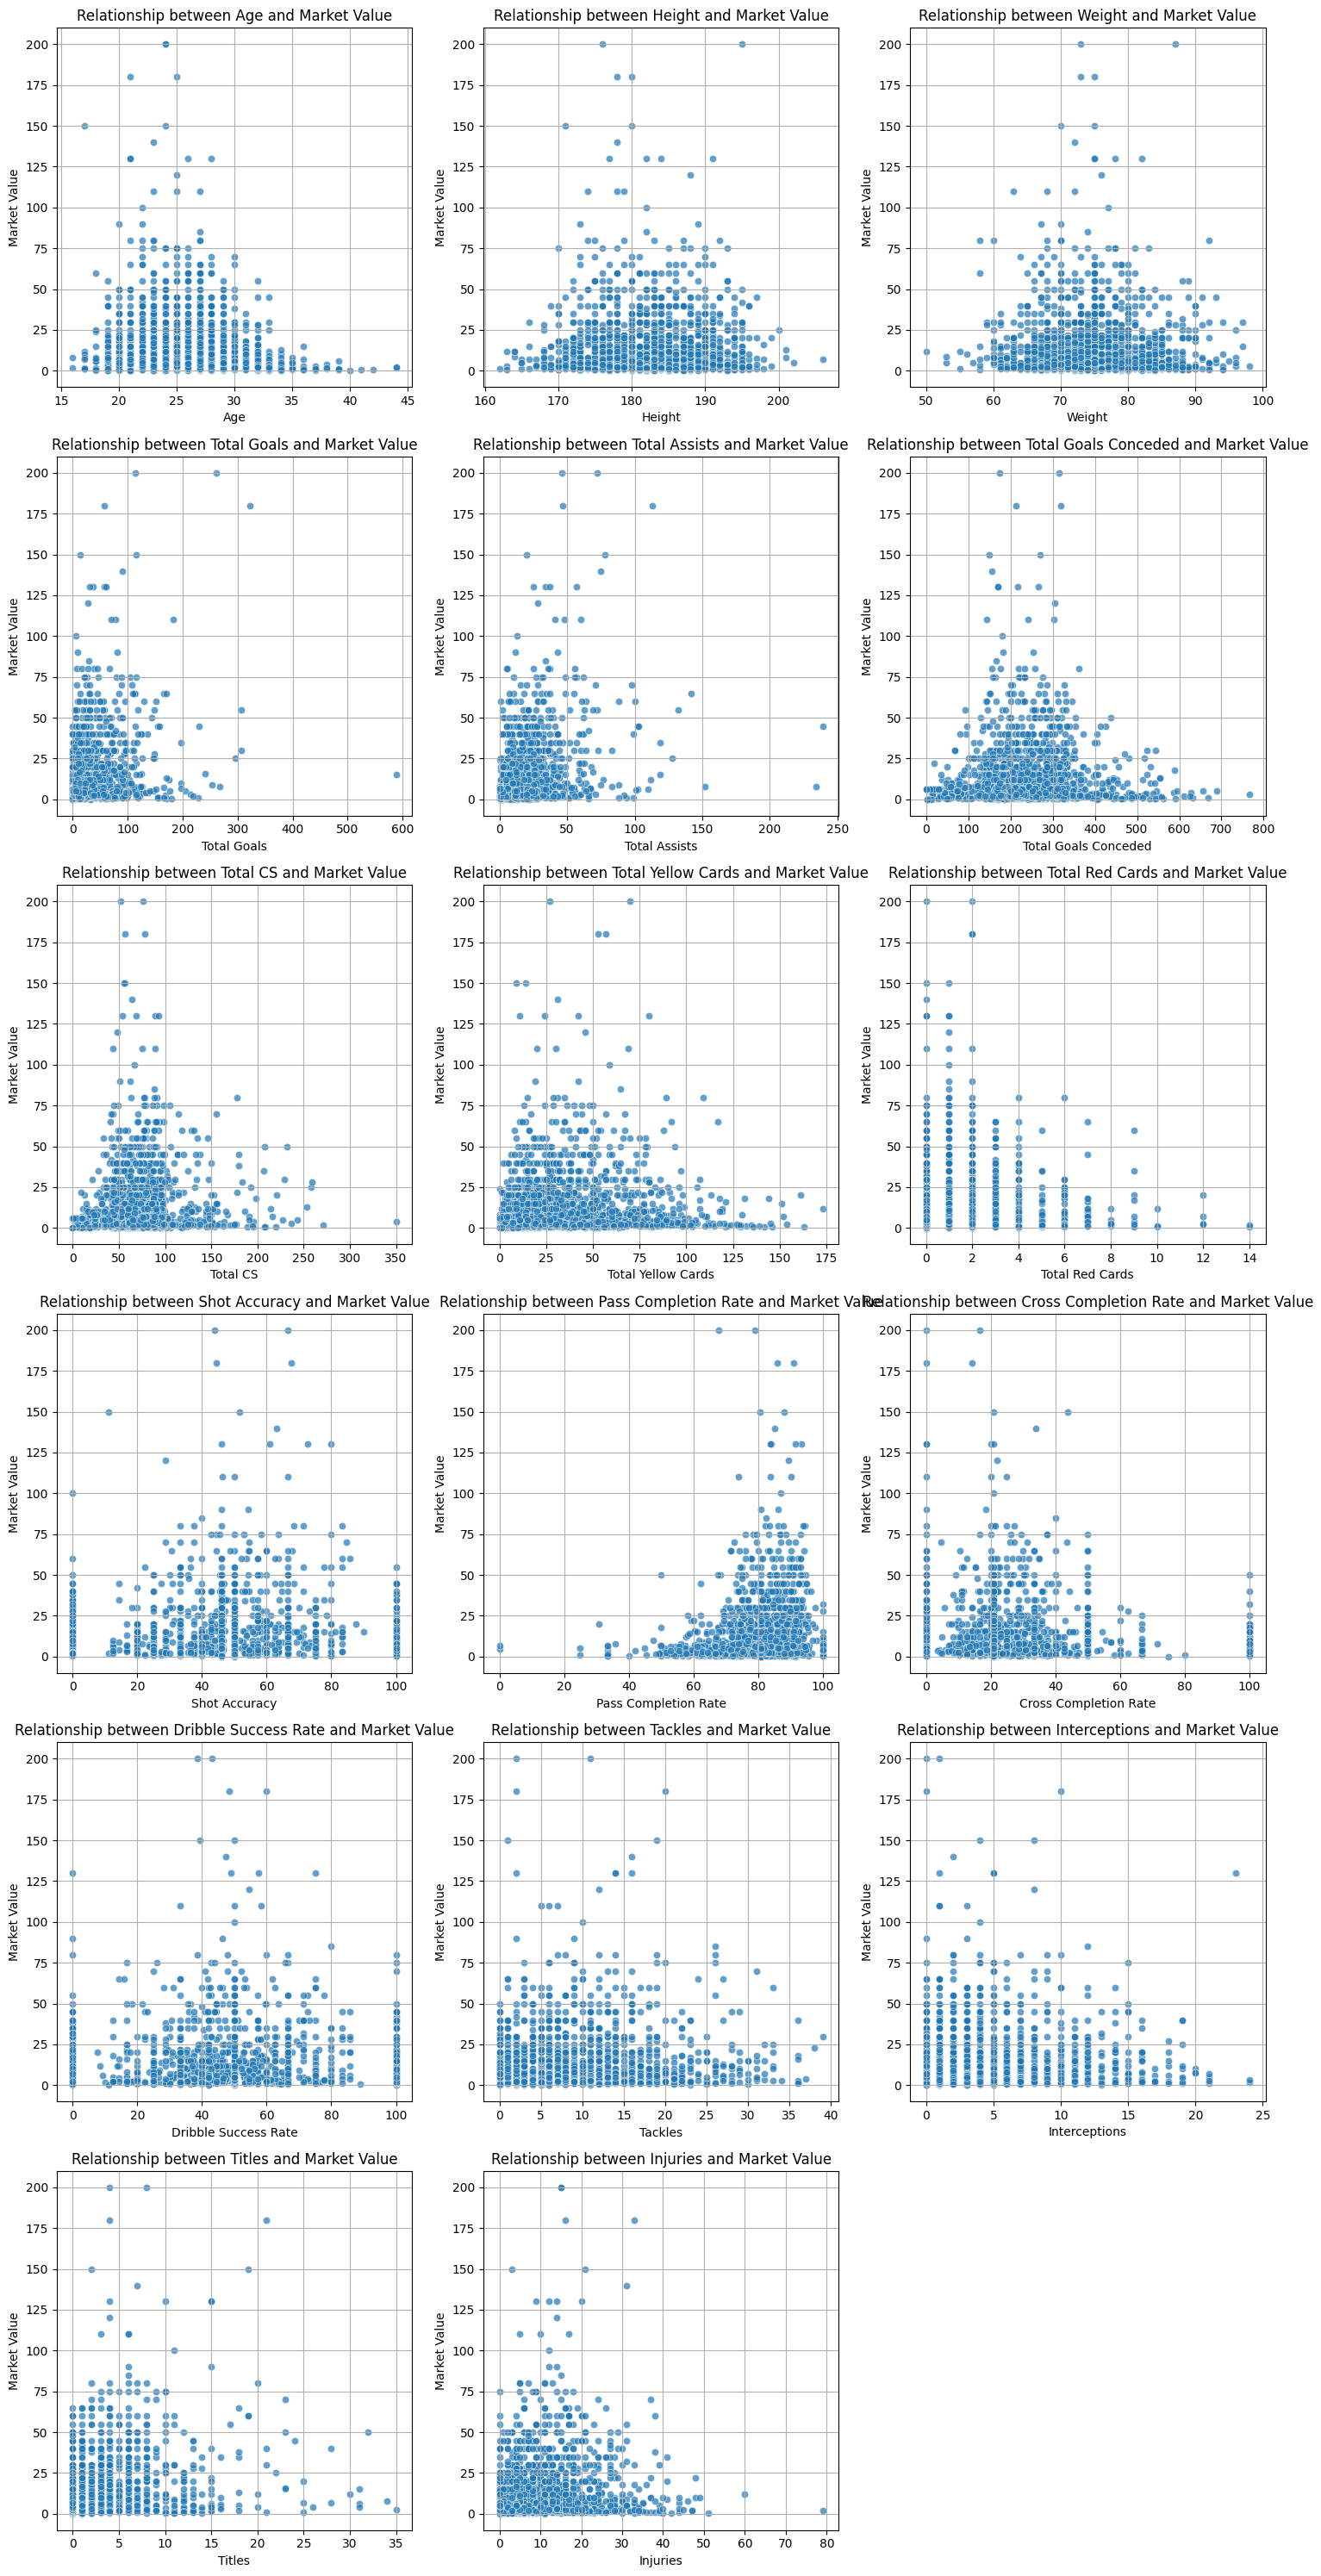

In [7]:
plot_all_numerical_columns(df,'Market Value')

In [8]:
# Treating Outliers
df.drop(df[df['Total Goals Conceded'] > 550].index, inplace=True)
df.drop(df[df['Market Value'] > 40].index, inplace=True)
df.drop(df[df['Total Assists'] > 75].index, inplace=True)
df.drop(df[df['Total Goals'] > 100].index, inplace=True)
df.drop(df[df['Total CS'] > 175].index, inplace=True)
print(df.shape)

(1635, 23)


- Also dribble success rates and shot accuracy are too evenly distributed across market value. They seemingly have no correlation with market value so I decided to drop them.

In [9]:
df = df.drop(columns=['Shot Accuracy','Dribble Success Rate'])

#### 2. As ther feature don't really correlate we can try find a new feature Score using Age, Total Goals, Total Assists for forward and midfielder and Age, Total CS for defender and goalkeepers.

In [10]:
# Apply conditional logic to calculate 'Score' based on position
df['Score'] = 0  # Initialize the 'Score' column

# For Forwards and Midfielders
df.loc[df['General Position'].isin(['Forward', 'Midfielder']), 'Score'] = (
    df['Age']**2 * (df['Total Goals'] + 1) + (df['Total Assists'] + 1)
)

# For Goalkeepers and Defenders
df.loc[df['General Position'].isin(['Goalkeeper', 'Defender']), 'Score'] = (
    df['Age']**2 * (df['Total CS'] + 1)
)
df['Score'] = np.log10(df['Score'])

C:\Users\84793\AppData\Local\Temp\ipykernel_8888\2477474445.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  3394.          9417.         23665.         14589.
   9003.          8135.         10166.         25942.
  79115.         31772.         10266.         10658.
  12790.         73227.          4763.          4699.
  30638.         34539.         82441.          5741.
  26108.         54928.          3382.         14294.
  78342.          3202.          8126.         43141.
  13472.         12183.         88169.         45961.
   6007.         11256.         12851.          2892.
   5015.         47130.         35869.         13793.
  45212.         36900.         29458.         69674.
  18989.         32829.          3886.          7430.
   5297.         11135.          5516.         19621.
  28632.          5011.         11274.           969.
  15570.          5757.          1814.         60

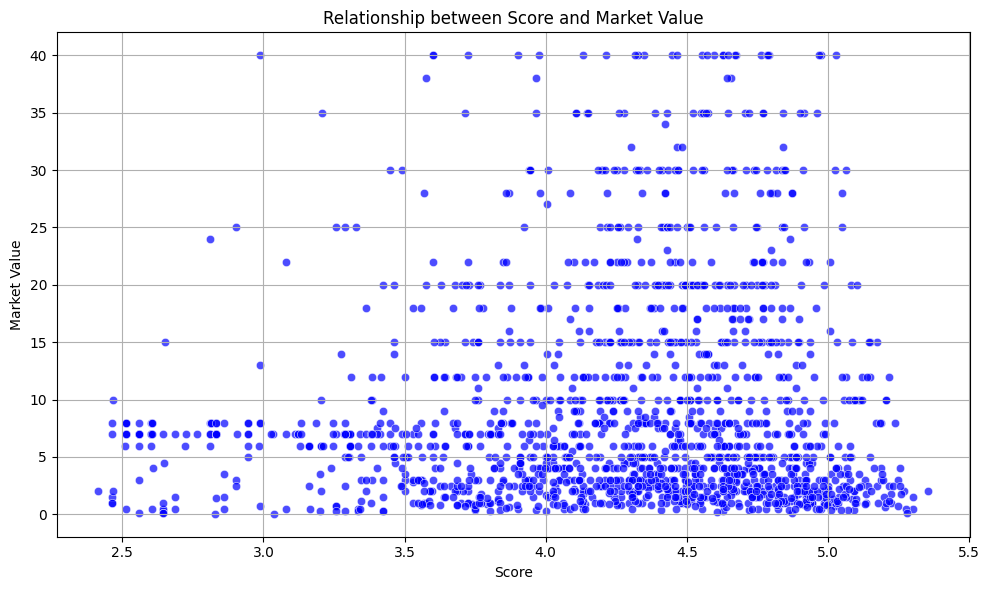

In [11]:
plot_relationship(df,'Score','Market Value')

#### 4. The remaining columns have somewhat more useful distribution and can extract information from them. So now I will perform transfomation on the data to resemble a bell curve for somewhat easier interpretation

In [12]:
right_skewed_columns = [col for col in df.select_dtypes('number').columns if (df[col].skew()  > 1 and col != 'Market Value')]
left_skewed_columns = [col for col in df.select_dtypes('number').columns if (df[col].skew()  < -1 and col != 'Market Value')]
for col in right_skewed_columns:
    df[f'log_{col}'] = np.log1p(df[col])  # Use log(1 + x) to handle zeros
for col in left_skewed_columns:
    df[f'log_reversed_{col}'] = np.log1p(df[col].max() + 1 - df[col])  # Reverse and log transform

# Drop the original columns
df = df.drop(columns=right_skewed_columns + left_skewed_columns)

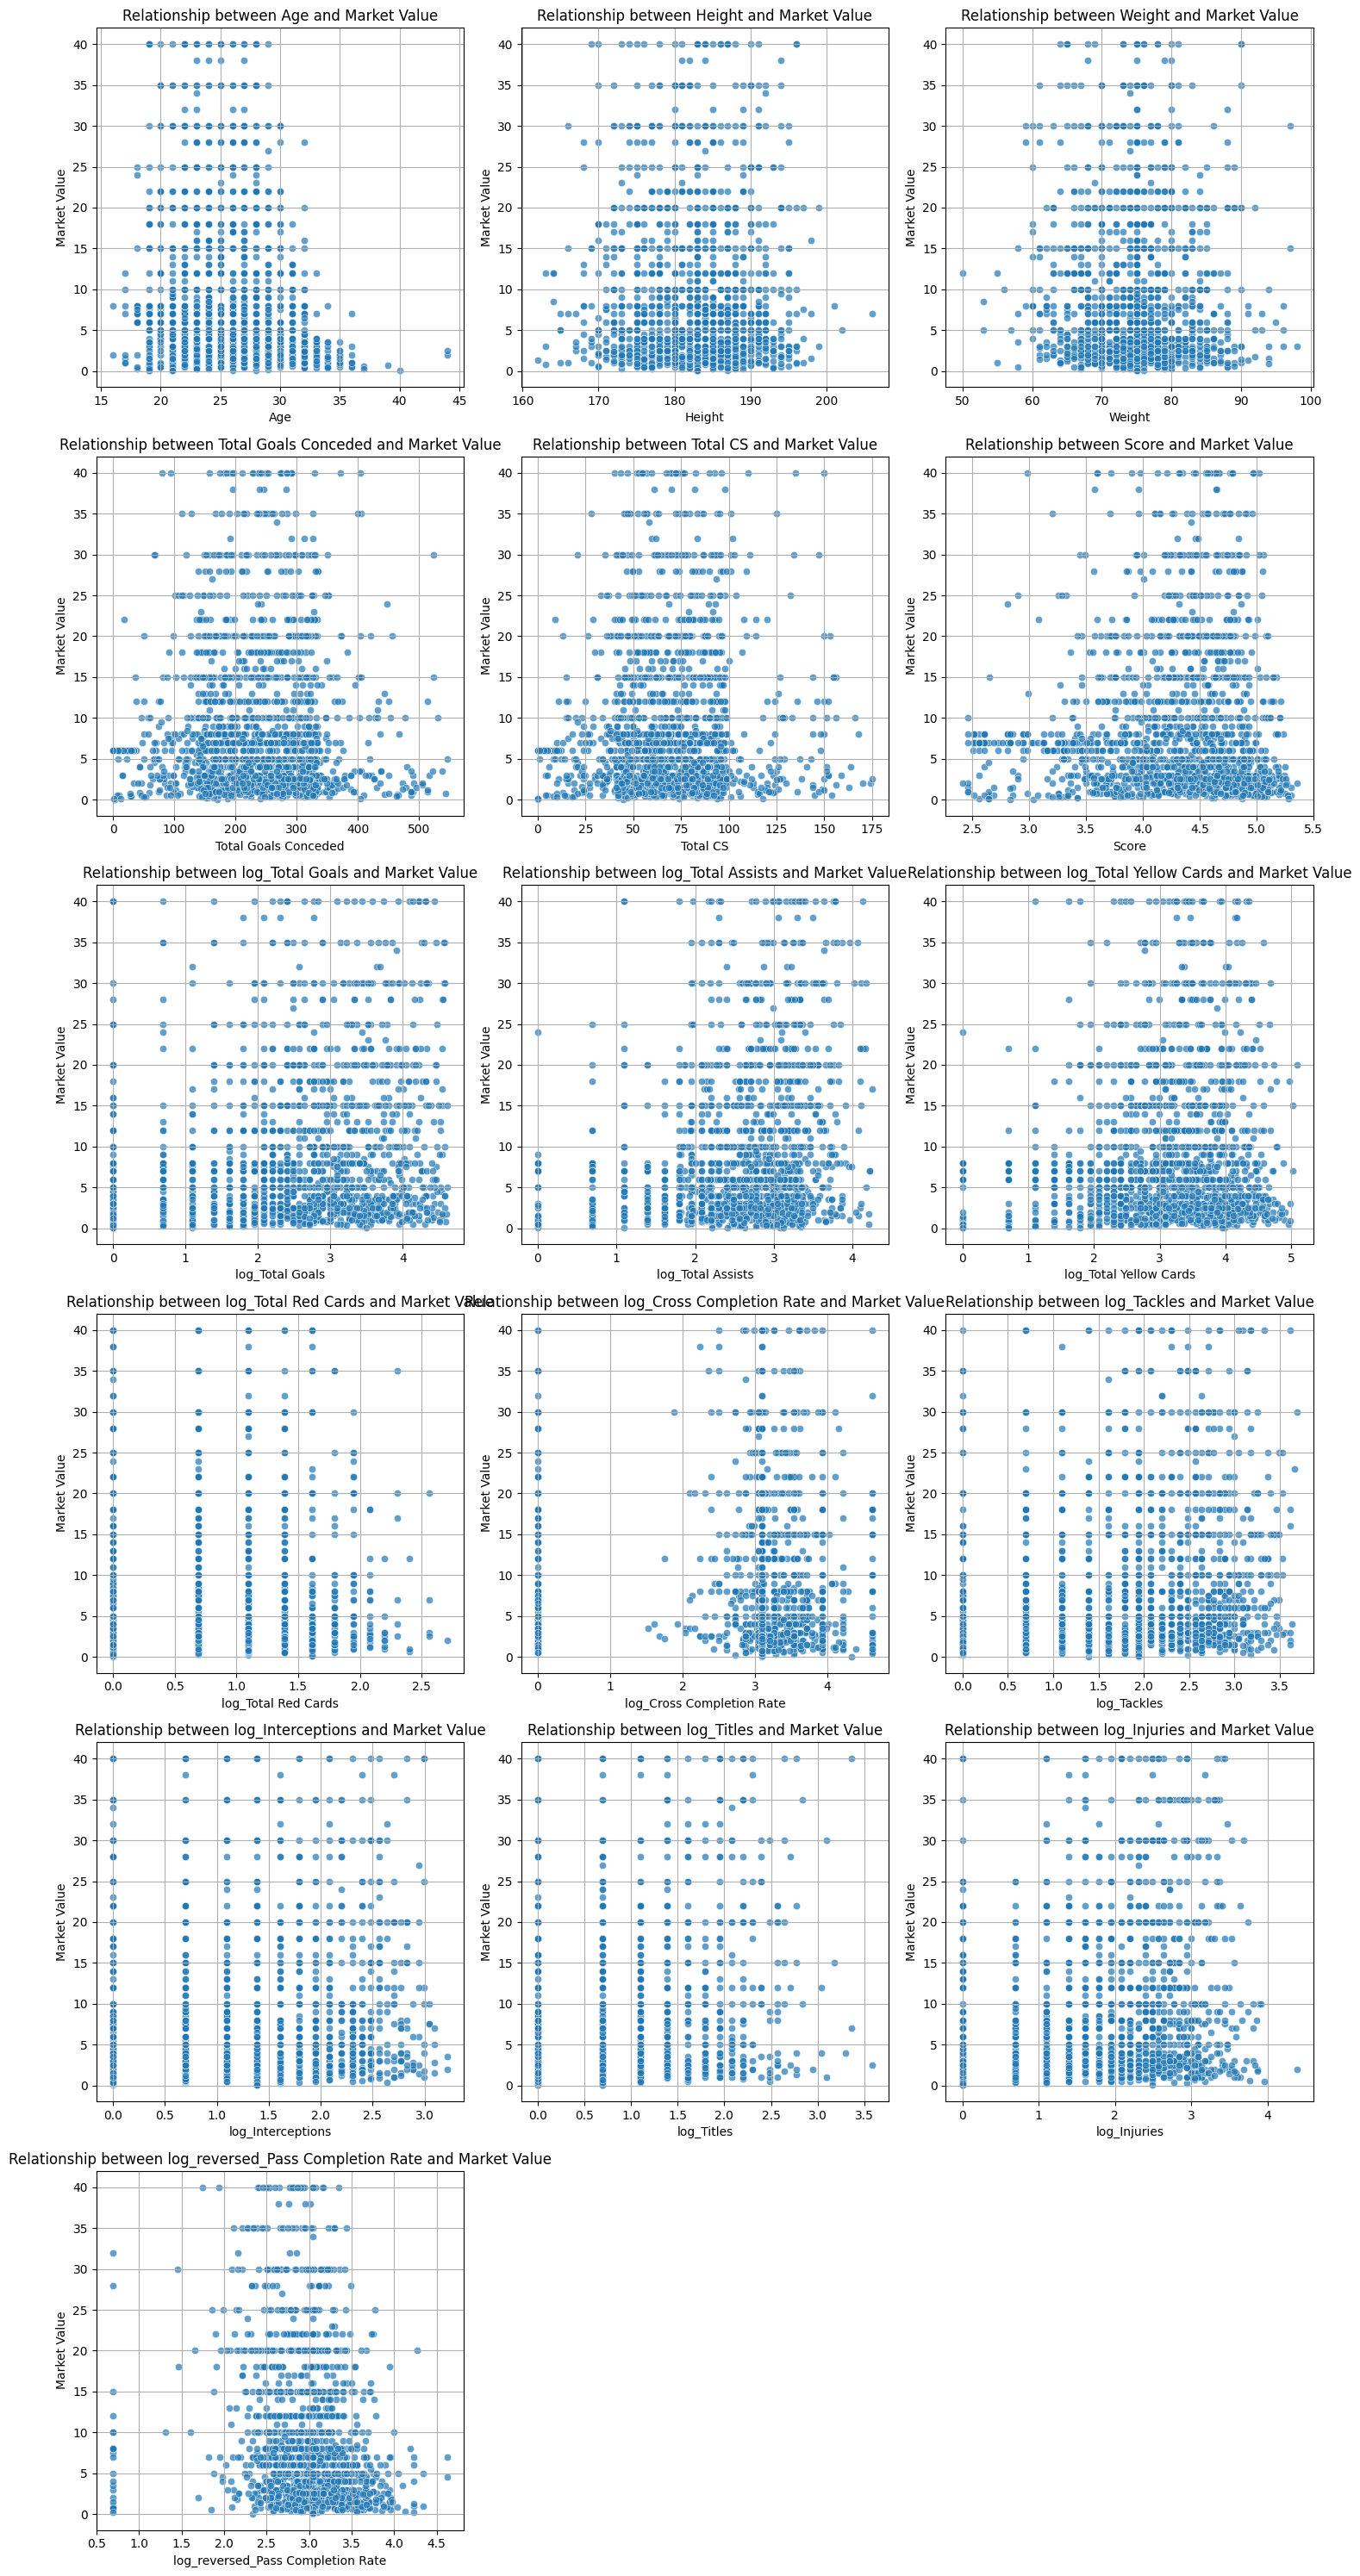

In [13]:
plot_all_numerical_columns(df, 'Market Value')

## Split the data into train set and test set

In [14]:
X = df.drop(['Market Value', 'Name', 'Nationality', 'Club', 'Foot', 'General Position'], axis=1)  # Replace 'target_column' with your actual target column name  
X.info()
y_market_value = df['Market Value']
y_position = df['General Position']

# Split data into train and test sets
# X_train_market_value, X_test_market_value, y_train_market_value, y_test_market_value = train_test_split(X, y_market_value, test_size=0.2, random_state=42)
# X_train_position, X_test_position, y_train_position, y_test_position = train_test_split(X, y_position, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Index: 1635 entries, 0 to 1874
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                1635 non-null   int64  
 1   Height                             1635 non-null   int64  
 2   Weight                             1635 non-null   int64  
 3   Total Goals Conceded               1635 non-null   float64
 4   Total CS                           1635 non-null   float64
 5   Score                              1635 non-null   float64
 6   log_Total Goals                    1635 non-null   float64
 7   log_Total Assists                  1635 non-null   float64
 8   log_Total Yellow Cards             1635 non-null   float64
 9   log_Total Red Cards                1635 non-null   float64
 10  log_Cross Completion Rate          1635 non-null   float64
 11  log_Tackles                        1635 non-null   float64
 1

### Init class for regression model

In [21]:
class RegressionModelEvaluator:
    def __init__(self, X, y, models, test_size=0.2, random_state=42):
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Store models
        self.models = models

        # Initialize results dictionary
        self.results = {}

    def evaluate_models(self):
        for name, model in self.models.items():
            # Create a pipeline for each model
            model_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', model)
            ])

            # Fit the model
            model_pipeline.fit(self.X_train, self.y_train)

            # Make predictions
            y_pred = model_pipeline.predict(self.X_test)

            # Calculate metrics
            metrics = {
                'MSE': mean_squared_error(self.y_test, y_pred),
                'RMSE': np.sqrt(mean_squared_error(self.y_test, y_pred)),
                'MAE': mean_absolute_error(self.y_test, y_pred),
                'MAPE': mean_absolute_percentage_error(self.y_test, y_pred),
                'R2': r2_score(self.y_test, y_pred)
            }

            # Store the metrics in the results dictionary
            self.results[name] = {
                'metrics': metrics,
                'predictions': y_pred
            }

        return self.results
    
    def visualize_predictions(self):
        """
        Create comprehensive visualizations of model predictions
        """
        plt.figure(figsize=(15, 5 * len(self.results)))
        
        for idx, (model_name, result) in enumerate(self.results.items(), 1):
            # Actual vs Predicted Plot
            plt.subplot(len(self.results), 2, 2*idx-1)
            plt.scatter(self.y_test, result['predictions'], alpha=0.7)
            plt.plot([self.y_test.min(), self.y_test.max()], 
                     [self.y_test.min(), self.y_test.max()], 
                     'r--', lw=2)
            plt.title(f'{model_name}: Actual vs Predicted')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')

        plt.tight_layout()
        plt.show()

    def print_detailed_metrics(self):
        """
        Print detailed metrics for each model
        """
        print("Detailed Model Performance Metrics:\n")
        for name, result in self.results.items():
            print(f"{name}:")
            for metric, value in result['metrics'].items():
                print(f"  {metric}: {value:.4f}")
            print()

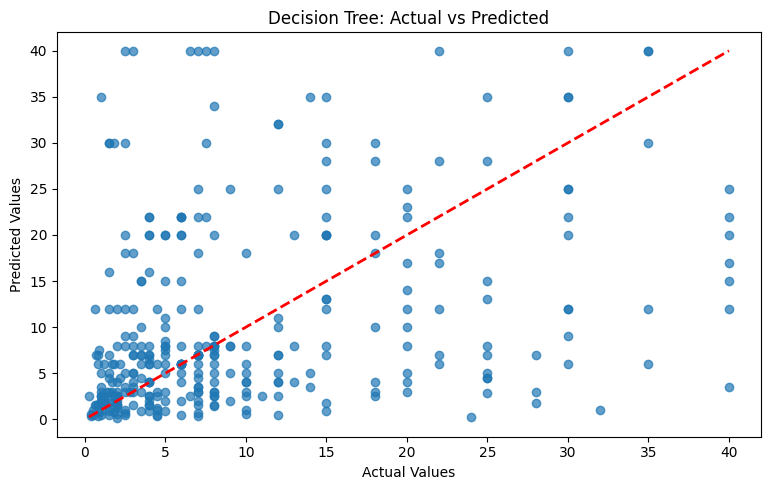

Detailed Model Performance Metrics:

Decision Tree:
  MSE: 126.6367
  RMSE: 11.2533
  MAE: 7.6337
  MAPE: 1.5288
  R2: -0.3969



In [23]:
# Define models to evaluate
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
}

# Initialize the evaluator
evaluator = RegressionModelEvaluator(X, y_market_value, models)

# Evaluate the models
results = evaluator.evaluate_models()

# Visualize the predictions
evaluator.visualize_predictions()

# Print detailed metrics
evaluator.print_detailed_metrics()

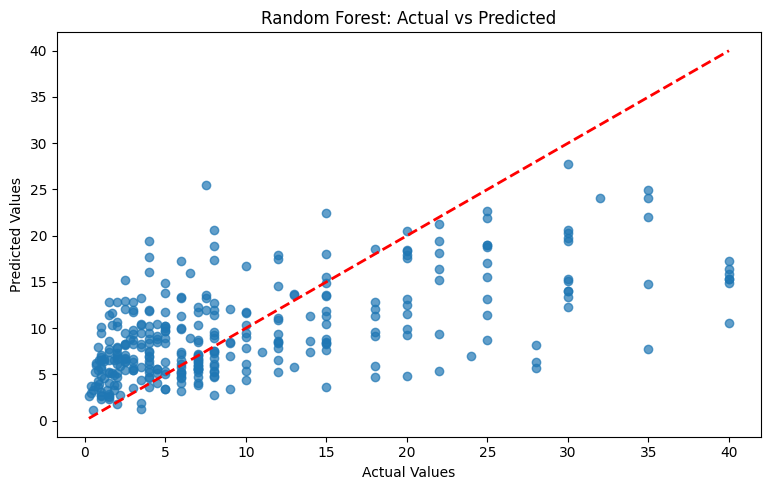

Detailed Model Performance Metrics:

Random Forest:
  MSE: 58.3726
  RMSE: 7.6402
  MAE: 5.5534
  MAPE: 1.3551
  R2: 0.3561



In [24]:
# Define models to evaluate
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
}

# Initialize the evaluator
evaluator = RegressionModelEvaluator(X, y_market_value, models)

# Evaluate the models
results = evaluator.evaluate_models()

# Visualize the predictions
evaluator.visualize_predictions()

# Print detailed metrics
evaluator.print_detailed_metrics()